<a href="https://colab.research.google.com/github/kavya2299/Image-Enhancement/blob/main/Modified_UNET_with_Augmentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Description

* This notebook gives a detailed understanding of the techniques used to enhance the ultrasound images in both a qualitative and quantitative manner
* Dataset: The data is divided into a training set of 999 images and a test set of 335 images. The size of each 2D ultrasound image is 800 by 540 pixels with a pixel size ranging from 0.052 to 0.326 mm.


# HFLIP,ROTATION AND LINEAR SHIFT


## Import Packages

In [ ]:
## these are basic system packages to access directories and files
import os
import time

## these are packages that we need to use to visualize the dataset 
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

## to make data augmentations
from torchvision.transforms import ToPILImage
from PIL import Image
import imutils
import cv2

## these are basic python packages
import math
import random
import csv

## these are packages that are a part of Pytorch, the deep-learning library
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## these are a few metrics used to make quantitative comparisons
from skimage.measure import compare_ssim
##from tabulate import tabulate


import wandb
wandb.login()

True

## GPU Availability


In [ ]:
# to check access to cuda
print(torch.cuda.is_available())

# if cuda is available, use cuda else cpu
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("running on gpu")
else:
    device = torch.device('cpu')
    print("running on cpu")  

True
running on gpu


## Defining the augment() function

In [ ]:
# x is an image 
mean = 0
sigma = 2

def augment(x):
    
    """
    We add the speckle noise(multiplicative gaussian noise) because it is usually present in any practical image. 
    Further, we make all sorts of augmentations to make the model robust. The augmentations imclude gamma 
    correction, rotation, horizontal flip, linear shifts. Then, a few others to adjust the non-linear intensity 
    inhomogeneity in the images and to account for shadow regions on the images by adding occulded patches.
    """
    # copy the image into 2 variables, one for the noisy image and the other for a clean image

    noisy_x = np.copy(x)
    clean_x = np.copy(x)
    
    # Add Speckle Noise   
    shape = noisy_x.shape[:2]
    intensity_noise = np.random.uniform(low=0.2, high=0.5)
    noisy_x = noisy_x*(1 + intensity_noise*np.random.normal(mean, sigma, size=shape[0]*shape[1]).reshape(shape[0],shape[1]).astype('float32'))

    # ROTATION
    angle = np.random.uniform(low=-10,high=10)
    noisy_x = imutils.rotate(noisy_x, angle) # cw for rotating the image in the clockwise direction, input a negative value  
    noisy_x = np.array(noisy_x)     
    clean_x = imutils.rotate(clean_x, angle) # cw for rotating the image in the clockwise direction, input a negative value  
    clean_x = np.array(clean_x)

    # HORIZONTAL FLIP
    if random.randint(0,1)==0:
        noisy_x = np.fliplr(noisy_x)
        clean_x = np.fliplr(clean_x)
    else:
        noisy_x = noisy_x
        clean_x = clean_x 
    
    #SHIFT
    hor = noisy_x.shape[0]
    vert = noisy_x.shape[1]
    percent = random.uniform(0,0.05)
    translate = np.float32([[1,0,percent*hor],[0,1,percent*vert]])

    noisy_x = cv2.warpAffine(noisy_x,translate,(noisy_x.shape[1],noisy_x.shape[0]))
    clean_x = cv2.warpAffine(clean_x,translate,(clean_x.shape[1],clean_x.shape[0]))

    
    #Resize the image to half its size
    dim = (400,270)
 
    noisy_x = cv2.resize(noisy_x, dim, interpolation = cv2.INTER_AREA)
    noisy_x=noisy_x[:256, :384]
    clean_x = cv2.resize(clean_x, dim, interpolation = cv2.INTER_AREA)
    clean_x=clean_x[:256, :384]
    
    #finally taking the norm in order to normalize the images
    norm_noisy = np.linalg.norm(noisy_x)
    norm_clean = np.linalg.norm(clean_x)

    noisy_x = noisy_x/norm_noisy
    clean_x = clean_x/norm_clean
    
    return clean_x,noisy_x

In [ ]:
def noise(x):
    noisy_x = np.copy(x)
    #clean_x = np.copy(x)
    
    # Add Speckle Noise   
    shape = noisy_x.shape[:2]
    intensity_noise = np.random.uniform(low=0.2, high=0.5)
    noisy_x = noisy_x*(1 + intensity_noise*np.random.normal(mean, sigma, size=shape[0]*shape[1]).reshape(shape[0],shape[1]).astype('float32'))
    
    dim = (400,270)
 
    noisy_x = cv2.resize(noisy_x, dim, interpolation = cv2.INTER_AREA)
    noisy_x = noisy_x[:256, :384]
    
    #finally taking the norm in order to normalize the images
    norm_noisy = np.linalg.norm(noisy_x)

    noisy_x = noisy_x/norm_noisy
    return x, noisy_x
    

## Data loaders


In [ ]:
"""
The train dataset generator is used to gather the unzipped files and sort them for easy access during training. 
"""

class train_dataset_generator(Dataset):
    def __init__(self,root_dir):
        self.image_filenames = []
        for filename in os.listdir(root_dir):
            if filename.endswith('HC.png'):
                self.image_filenames.append(os.path.join(root_dir,filename))
                self.image_filenames.sort()
                
        self.transforms = transforms.Compose([                  
                          transforms.ToTensor()]) # the mean and variance can be obtained from the cell below
        
    def __len__(self):
        return len(self.image_filenames)

    def get_basename(self,index):
        print (os.path.basename(self.image_filenames[index])) 

    def show(self,index):
        image = (cv2.imread(self.image_filenames[index],0))
        plt.imshow(image,cmap='gray')

    def __getitem__(self,index):
        image_orig = cv2.imread(self.image_filenames[index],0)
        image = np.copy(image_orig)
        image_orig,image = augment(image)
        image_orig,image = np.float32(image_orig),np.float32(image)
        image_orig,image = self.transforms(image_orig),self.transforms(image)
        
        #self.images = transforms.ToTensor(np.asarray([image, rotate(image), gaussian_noise(image), speckle_noise(image), hflip(image), non_linear_intensity(image)]))
        return image_orig,image
    

"""
The test dataset generator is used to gather the unzipped files and sort themfor easy access. 
"""

class test_dataset_generator(Dataset):
    def __init__(self,root_dir):
        self.image_filenames = []
        for filename in os.listdir(root_dir):
            if filename.endswith('.png'):
                self.image_filenames.append(os.path.join(root_dir,filename))
                self.image_filenames.sort()
        self.transforms = transforms.Compose([
                          transforms.ToTensor()])#,
                         # transforms.Normalize((0,),(1,))])#mean,variance
        
    def __len__(self):
        return len(self.image_filenames)

    def get_basename(self,index):
        print (os.path.basename(self.image_filenames[index])) 

    def show(self,index):
        image = (cv2.imread(self.image_filenames[index],0))
        plt.imshow(image,cmap='gray')

    def __getitem__(self,index):
        image_orig = cv2.imread(self.image_filenames[index],0)
        image = np.copy(image_orig)
        image_orig,image = augment(image)
        image_orig,image = np.float32(image_orig),np.float32(image)
        image_orig,image = self.transforms(image_orig),self.transforms(image)
        
        #self.images = transforms.ToTensor(np.asarray([image, rotate(image), gaussian_noise(image), speckle_noise(image), hflip(image), non_linear_intensity(image)]))
        return image_orig,image           



### Load the dataset into the data loaders


In [ ]:
"""
Load the paths into the data generators to load into the data loaders. 
Create a split of 90:10 train:validation.
Declare the batch size in accordance with the amount of GPU used 
"""
# generate the data for both train and test
# modify the path according to your need
train_dataset = train_dataset_generator('/home/beagle/Dropbox/IMAGE ENHANCEMENT/KAVYA/HC 18 dataset/training_set')
test_dataset = test_dataset_generator('/home/beagle/Dropbox/IMAGE ENHANCEMENT/KAVYA/HC 18 dataset/Test_11')

len_valid_set = int(0.1*len(train_dataset))
len_train_set = len(train_dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len(test_dataset)))

# vary the batch size as and when needed
batch_size = 2

# split the dataset into train and validation datasets
train_dataset , valid_dataset = torch.utils.data.random_split(train_dataset, [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,shuffle=True)

The length of Train set is 900
The length of Valid set is 99
The length of Test set is 11


### Sanity check of the data from the dataloader

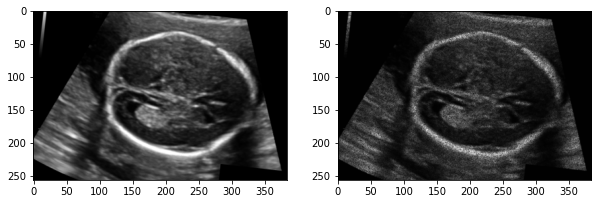

In [ ]:
"""
This cell is to visualize how the corresponding original image is made noisier 
with the help of the augment function
"""
image = next(iter(train_loader))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(image[0][0].squeeze(0),cmap='gray')
plt.subplot(122)
plt.imshow(image[1][0].squeeze(0),cmap='gray')

## Architecture


In [ ]:
## define the NN architecture
import torch
#from torchsummary import summary
import torch.nn as nn

class ConvDenoiser(nn.Module):

    """
    this is the network that is used for the image enhancement task 
    """
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## downsampling blocks with ELU activations
        self.conv1 = nn.Sequential(
                      nn.Conv2d(1,64,3,padding=1),
                      nn.ELU(),
                      nn.Conv2d(64,64,3,padding=1),
                      nn.ELU())
        self.conv2 = nn.Sequential(
                      nn.Conv2d(64,128,3,padding=1),
                      nn.ELU(),
                      nn.Conv2d(128,128,3,padding=1),
                      nn.ELU())
        self.conv3 = nn.Sequential(
                      nn.Conv2d(128,256,3,padding=1),
                      nn.ELU(),
                      nn.Conv2d(256,256,3,padding=1),
                      nn.ELU())
        self.conv4 = nn.Sequential(
                      nn.Conv2d(256,512,3,padding=1),
                      nn.ELU(),
                      nn.Conv2d(512,512,3,padding=1),
                      nn.ELU())
        
        ## bottleneck/latent space
        self.bottleneck = nn.Sequential(
                          nn.Conv2d(512,1024,3,padding=1),
                          nn.ELU(),
                          nn.Conv2d(1024,1024,3,padding=1),
                          nn.ELU())
        
        ## transposed convolutional layer
        self.t_conv4 = nn.ConvTranspose2d(1024,512,2,stride=2)
        self.t_conv3 = nn.ConvTranspose2d(512,256,2,stride=2)
        self.t_conv2 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.t_conv1 = nn.ConvTranspose2d(128,64,2,stride=2)

        ## maxpooling layer
        self.pool = nn.MaxPool2d(2,2)

        ## upsampling blocks with ELU activations
        self.upconv4 = nn.Sequential(
                        nn.Conv2d(1024,512,3,padding=1),
                        nn.ELU(),
                        nn.Conv2d(512,512,3,padding=1),
                        nn.ELU())
        self.upconv3 = nn.Sequential(
                        nn.Conv2d(512,256,3,padding=1),
                        nn.ELU(),
                        nn.Conv2d(256,256,3,padding=1),
                        nn.ELU())
        self.upconv2 = nn.Sequential(
                        nn.Conv2d(256,128,3,padding=1),
                        nn.ELU(),
                        nn.Conv2d(128,128,3,padding=1),
                        nn.ELU())
        self.upconv1 = nn.Sequential(
                        nn.Conv2d(128,64,3,padding=1),
                        nn.ELU(),
                        nn.Conv2d(64,64,3,padding=1),
                        nn.ELU())
        
        ## output function
        self.out = nn.Sequential(
                  nn.Conv2d(64, 1, 3, padding=1),
                  nn.Tanh())
         
    def forward(self, x):
        ## encoding blocks

        conv1 = self.conv1(x)
        pool1 = self.pool(conv1)
        conv2 = self.conv2(pool1)
        pool2 = self.pool(conv2)
        conv3 = self.conv3(pool2)
        pool3 = self.pool(conv3)    
        conv4 = self.conv4(pool3)
        pool4 = self.pool(conv4)
        
        ## bottleneck
        bottleneck = self.bottleneck(pool4)

        ## decoding blocks

        t_conv4 = self.t_conv4(bottleneck)
        concat4 = torch.cat((conv4,t_conv4),1)
        upconv4 = self.upconv4(concat4)

        t_conv3 = self.t_conv3(upconv4)
        concat3 = torch.cat((conv3,t_conv3),1)
        upconv3 = self.upconv3(concat3)

        t_conv2 = self.t_conv2(upconv3)
        concat2 = torch.cat((conv2,t_conv2),1)
        upconv2 = self.upconv2(concat2)

        t_conv1 = self.t_conv1(upconv2)
        concat1 = torch.cat((conv1,t_conv1),1)
        upconv1 = self.upconv1(concat1)

        ## output function
        out = self.out(upconv1)
        return out
## instantiate an object of the class and move the network to the GPU if available
model = ConvDenoiser().to(device)

## to use a best network variable for storing the best state of the model over the epochs 
best_network = ConvDenoiser().to(device)
print(model)

ConvDenoiser(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ELU(alpha=1.0)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ELU(alpha=1.0)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ELU(alpha=1.0)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ELU(alpha=1.0)
  )
  (bottleneck): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), s

In [ ]:
# to access all the parameters at once
# parameters in the module class
# each layer has a bias and weights
for param in ConvDenoiser.parameters(model):
  print(param.shape)

torch.Size([64, 1, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([1024, 512, 3, 3])
torch.Size([1024])
torch.Size([1024, 1024, 3, 3])
torch.Size([1024])
torch.Size([1024, 512, 2, 2])
torch.Size([512])
torch.Size([512, 256, 2, 2])
torch.Size([256])
torch.Size([256, 128, 2, 2])
torch.Size([128])
torch.Size([128, 64, 2, 2])
torch.Size([64])
torch.Size([512, 1024, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([256, 512, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([128, 256, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([64, 128, 3, 3])
torch.Size([64])
torch.Size([64, 64

## Training

In [ ]:
def get_correct(output,input):
    ## to get the number of images that closely match their inputs
    return output.eq(input).sum().item()

In [ ]:
# initialize the wandb project and entity
wandb.init(name='Augmentation_check2', entity='Viekash', project='fetal-imaging', config = {'epochs': 120})

# initiate the best loss to 0
best_loss = 0.0

# specify loss function
criterion = nn.MSELoss()

# specify optimizer, here, we use SGD with 0 momentum and learning rate of 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

def train(network):

    """
    This function is used to train the network by adding a random noise to the images. The loss function used is RMSE and the optimizer 
    are defined below. 
    
    There exists a noise factor to define the amount of noise added to the baseline images. Input a noise factor to train the network given 
    that amount of noise. Once the noise is added, we move both the noisy images and the original baseline images to the GPU and then we 
    process the outputs over the network and obtain the predictions. 
    
    The outputs must be such that they must closely resemble the baseline images (without noise) and remove the innate noise in the baseline.
    The loss computed is given by the train_loss.

    """

    # monitor training loss
    train_loss = 0.0

    # monitor training accuracy
    train_accuracy = 0.0
    total_correct = 0
    
    # load data and generate both noisy and clean counterparts
    train_dataset = train_dataset_generator('/home/beagle/Dropbox/IMAGE ENHANCEMENT/KAVYA/HC 18 dataset/training_set')
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    print("data loaded for "+ str(epoch+1))
    network.train()    

    for data in train_loader:
        # assigning the original images 
        images = data[0][:] 
        images = images.float()

        # assigning the noisy images 
        noisy_imgs = data[1][:]

        # move the noisy images and the input images to gpu for computation
        noisy_imgs = noisy_imgs.to(device)
        images = images.to(device)

        # clear the gradients of all optimized variables to ensure they are all initialized to 0
        optimizer.zero_grad()

        # forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = network(noisy_imgs)

        # calculate the RMSE loss
        # the "target" is still the original, clean images
        loss = torch.sqrt(criterion(outputs, images))

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        # here it will be for a specific batch of data
        optimizer.step()

        # update running training loss
        train_loss += loss.item()

        # get the accuracy on the training dataset by accumulating the number of correct items
        total_correct += get_correct(outputs,images)
        
    # get the average training statistics for every epoch
    train_loss = train_loss/len(train_loader)
    train_accuracy = total_correct/len(train_loader)

    return train_loss, train_accuracy

def validation(network):
  
    """
    This function is used to validate the network by adding a random noise to the images. The loss function used is RMSE and the optimizer 
    are defined below. 
    
    Once the noise is added, we move both the noisy images and the original baseline images to the GPU and then we 
    process the outputs over the network and obtain the predictions. 
    
    The outputs must be such that they must closely resemble the baseline images (without noise) and remove the innate noise in the baseline.
    The loss computed is given by the train_loss.

    """
    # monitor the validation loss and accuracy
    val_loss = 0.0
    val_accuracy = 0.0
    val_correct = 0
    
    network.eval()
    
    for data in valid_loader:
        # assigning the original images 
        images = data[0][:]

        # assigning the noisy images 
        noisy_images = data[1][:]

        # move the input images and the noisy images to the gpu 
        noisy_images = noisy_images.to(device)
        images = images.to(device)

        # get the predictions from the network 
        output = network(noisy_images)

        # get the validation losses
        valid_loss = torch.sqrt(criterion(output, images.float()))
        val_loss += valid_loss.item()    

        # get the validation accuracy
        val_correct += get_correct(output,images)

    # get the average validation statistics 
    val_loss = val_loss/len(valid_loader)
    val_accuracy = val_correct/len(valid_loader)
    return val_loss, val_accuracy
        
for epoch in range(0, wandb.config.epochs):    
    
    train_loss, train_accuracy = train(model)
    
    val_loss, val_accuracy = validation(model)

    if epoch == 0:
        best_loss = val_loss
        best_network = model
        print("best model saved for ",str(epoch+1))
        torch.save(model.state_dict(), '/home/beagle/Dropbox/IMAGE ENHANCEMENT/KAVYA/Best models/S-UNET_aug_check2.pth')
    

    elif epoch > 0 and val_loss < best_loss:
        best_loss = val_loss
        best_network = model
        print("best model saved for ",str(epoch+1))
        torch.save(model.state_dict(), '/home/beagle/Dropbox/IMAGE ENHANCEMENT/KAVYA/Best models/S-UNET_aug_check2.pth')
    

    # save the best model every epoch so as to be able to resume from where it was left to train
    # the path should be mentioned as .pth   

    #torch.save(model.state_dict(), '/home/beagle/Dropbox/IMAGE ENHANCEMENT/KAVYA/Best models/S-UNET_no_augment.pth')
    print('Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f} \tTrain Accuracy: {:.2f} \tValidation Accuracy: {:.2f} '.format(epoch+1,train_loss,val_loss,train_accuracy,val_accuracy))
    wandb.log({'training loss': train_loss,
                 'validation loss': val_loss,
                 'training accuracy': train_accuracy,
                 'validation_accuracy': val_accuracy})


data loaded for 1
best model saved for  1
Epoch: 1 	Training Loss: 0.0025 	Validation Loss: 0.0024 	Train Accuracy: 0.00 	Validation Accuracy: 0.00 
data loaded for 2
best model saved for  2
Epoch: 2 	Training Loss: 0.0024 	Validation Loss: 0.0023 	Train Accuracy: 0.00 	Validation Accuracy: 0.00 
data loaded for 3
Epoch: 3 	Training Loss: 0.0023 	Validation Loss: 0.0023 	Train Accuracy: 0.01 	Validation Accuracy: 0.00 
data loaded for 4
Epoch: 4 	Training Loss: 0.0023 	Validation Loss: 0.0024 	Train Accuracy: 0.01 	Validation Accuracy: 0.00 
data loaded for 5
best model saved for  5
Epoch: 5 	Training Loss: 0.0022 	Validation Loss: 0.0022 	Train Accuracy: 0.00 	Validation Accuracy: 0.02 
data loaded for 6
Epoch: 6 	Training Loss: 0.0022 	Validation Loss: 0.0022 	Train Accuracy: 0.01 	Validation Accuracy: 0.00 
data loaded for 7
best model saved for  7
Epoch: 7 	Training Loss: 0.0022 	Validation Loss: 0.0021 	Train Accuracy: 0.00 	Validation Accuracy: 0.00 
data loaded for 8
Epoch: 8 	T

Epoch: 63 	Training Loss: 0.0018 	Validation Loss: 0.0018 	Train Accuracy: 0.01 	Validation Accuracy: 0.00 
data loaded for 64
Epoch: 64 	Training Loss: 0.0018 	Validation Loss: 0.0018 	Train Accuracy: 0.00 	Validation Accuracy: 0.00 
data loaded for 65
Epoch: 65 	Training Loss: 0.0018 	Validation Loss: 0.0017 	Train Accuracy: 0.00 	Validation Accuracy: 0.00 
data loaded for 66
Epoch: 66 	Training Loss: 0.0018 	Validation Loss: 0.0019 	Train Accuracy: 0.00 	Validation Accuracy: 0.00 
data loaded for 67
Epoch: 67 	Training Loss: 0.0017 	Validation Loss: 0.0018 	Train Accuracy: 0.01 	Validation Accuracy: 0.00 
data loaded for 68
Epoch: 68 	Training Loss: 0.0017 	Validation Loss: 0.0018 	Train Accuracy: 0.00 	Validation Accuracy: 0.00 
data loaded for 69
best model saved for  69
Epoch: 69 	Training Loss: 0.0017 	Validation Loss: 0.0017 	Train Accuracy: 0.01 	Validation Accuracy: 0.00 
data loaded for 70
Epoch: 70 	Training Loss: 0.0017 	Validation Loss: 0.0017 	Train Accuracy: 0.00 	Valid

## Quantitative Analysis of the test images 

In [ ]:
def psnr(img1,img2):
    """
    to get the psnr values of the images
    """

    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    maxi = 255 # img1 should be the original img
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
      return 100
    else:
      return(20*math.log(maxi / math.sqrt(mse)))

def ssim(img1,img2):
    """
    to get the ssim values for the images
    """
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    score,diff = compare_ssim(img1,img2,full=True)
    return score    


## Test on the test data

In [ ]:
# load the best model saved onto the gpu to test the data

model.load_state_dict(torch.load('/home/beagle/Dropbox/IMAGE ENHANCEMENT/KAVYA/Best models/S-UNET_aug_check2.pth', map_location=torch.device('cuda')))

<All keys matched successfully>

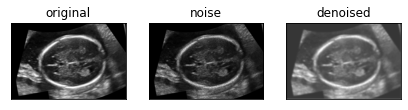

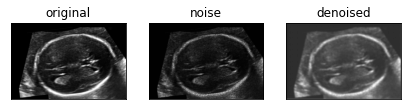

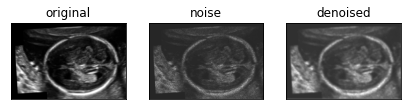

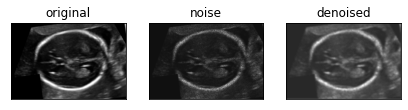

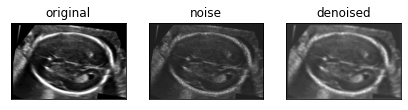

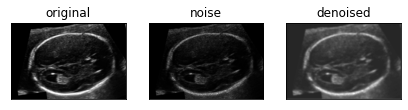

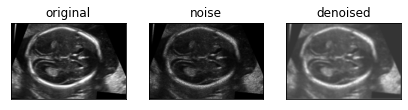

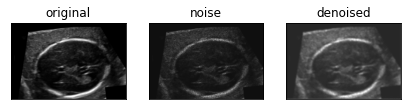

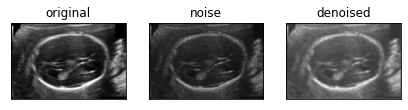

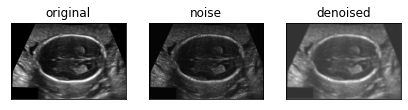

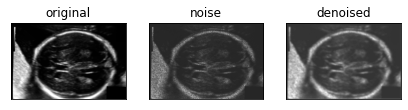

In [ ]:
def test(network): 

    """
    This function is used to test the network on the test data by adding a random noise to the images. 
    
    Once the noise is added, we move both the noisy images and the original baseline images to the GPU and then we 
    process the outputs over the network and obtain the predictions. 
    
    The outputs must be such that they must closely resemble the baseline images (without noise) and remove the innate noise in the baseline.
    Then, these images are moved into the CPU for the purpose of visualization of the images in the order, "noisy, enhanced, original".
    """

    count = 0

    for data in test_loader:

        #images = data[0][:]
        images = data[0][:]
        noisy_imgs = data[1][:]
        images = images.float()
        # move the input images to gpu for computation
        noisy_imgs = noisy_imgs.to(device)
        images = images.to(device)       
        output = network(noisy_imgs)
        
        # further, move the images and the output to visualize
        output = output.cpu()
        #output = network(images)
        
        images = images.cpu()
        noisy_imgs = noisy_imgs.cpu()
        """
        print(len(data))
        print(noisy_imgs.squeeze(dim=1).shape)
        print(output.squeeze(dim=1).shape)
        print(images.squeeze(dim=1).shape)
        """
        noisy_imgs = noisy_imgs.squeeze(dim=1)
        output = output.squeeze(dim=1)
        images = images.squeeze(dim=1)
        
        
        # use detach when it's an output that requires_grad
        output = output.detach().numpy()        

        img = [images[0], noisy_imgs[0], output[0]]
        titles = {1 : "original", 2 : "noise", 3 : "denoised"}
        plt.figure(figsize=(7,7))
        #print(titles[1])
        for j in range(3):
            plt.subplot(1,3,j+1)
            plt.title(titles[j+1])
            ax = plt.imshow(img[j],cmap='gray')
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
        plt.savefig("/home/beagle/Dropbox/IMAGE ENHANCEMENT/KAVYA/Test_results/test_augment_rotation_aug_"+str(count)+".png", facecolor='black', bbox_inches = 'tight')
        plt.show()

        count += 1

test(model)